# Feature Extractions, PCA, Normality Test
- Name: Minh T. Nguyen
- Date: 11/24/2023
- About:
    - **Description Sentiment Analysis**: Use pretrained models to performed sentimental analysis and create new feature.
    - **Features Extraction**: Based on the provided features let's create new features.
        - Use the processed sentiment dataset
    - **Clean up the dataset for classical ML modeling.**

In [1]:
!ls ../data

database.db		     sentimental_extraction_kaggle.csv
final_dataset_image.json     sentimental_extraction_kaggle.json
final_dataset_no_image.json  sentimental_extraction_sample.csv
images_sample		     train.json
Kaggle-renthop.torrent


**Note:** The datasets can be found [here]((https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/data?select=train.json.zip)).
- train.json: the training set.
- images_sample.zip: listing images organized by listing_id (a sample of 100 listings)
- Kaggle-renthop.7z: listing images organized by listing_id. Total size: 78.5 GB compressed.

In [2]:
# import libraries
import numpy as np
import pandas as pd
from collections import Counter
import re
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from numpy.linalg import svd
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

/home/mnguyen0226/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mnguyen0226/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## 1. Import dataset

In [3]:
# import the dataset (this dataset has already remove outlier)
df = pd.read_json("../data/sentimental_extraction_kaggle.json")
df.head(5)

bathrooms  bedrooms                       building_id  \
4         1.0         1  8579a0b0d54db803821a35a4a615e97a   
6         1.0         2  b8e75fc949a6cd8225b455648a951712   
9         1.0         2  cd759a988b8f23924b5a2058d5ab2b49   
10        1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
15        1.0         0  bfb9405149bfff42a92980b594c28234   

                created                                        description  \
4   2016-06-16 05:55:27  Spacious 1 Bedroom 1 Bathroom in Williamsburg!...   
6   2016-06-01 05:44:33  BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...   
9   2016-06-14 15:19:59  **FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...   
10  2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
15  2016-06-28 03:50:23  Over-sized Studio w abundant closets. Availabl...   

        display_address                                           features  \
4   145 Borinquen Place  [Dining Room, Pre-War, Laundry in Building, Di...   
6             East 44th  [Doorman, Elevator, Laundry in Building, Dishw...   
9      East 56th Street  [Doorman, Elevator, Laundry in Building, Laund...   
10  Metropolitan Avenue                                                 []   
15     East 34th Street  [Doorman, Elevator, Fitness Center, Laundry in...   

    latitude  listing_id  longitude                        manager_id  \
4    40.7108     7170325   -73.9539  a10db4590843d78c784171a107bdacb4   
6    40.7513     7092344   -73.9722  955db33477af4f40004820b4aed804a0   
9    40.7575     7158677   -73.9625  c8b10a317b766204f08e613cef4ce7a0   
10   40.7145     7211212   -73.9425  5ba989232d0489da1b5f2c45f6688adc   
15   40.7439     7225292   -73.9743  2c3b41f588fbb5234d8a1e885a436cfa   

                                               photos  price  \
4   [https://photos.renthop.com/2/7170325_3bb5ac84...   2400   
6   [https://photos.renthop.com/2/7092344_7663c19a...   3800   
9   [https://photos.renthop.com/2/7158677_c897a134...   3495   
10  [https://photos.renthop.com/2/7211212_1ed4542e...   3000   
15  [https://photos.renthop.com/2/7225292_901f1984...   2795   

             street_address interest_level  \
4       145 Borinquen Place         medium   
6             230 East 44th            low   
9      405 East 56th Street         medium   
10  792 Metropolitan Avenue         medium   
15     340 East 34th Street            low   

                                    clean_description  \
4   Spacious 1 Bedroom 1 Bathroom in Williamsburg!...   
6   BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...   
9   **FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...   
10  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
15  Over-sized Studio w abundant closets. Availabl...   

                                truncated_description  \
4   spacious 1 bedroom 1 bathroom in williamsburg!...   
6   brand new gut renovated true 2 bedroomfind you...   
9   * * flex 2 bedroom with full pressurized wall ...   
10  a brand new 3 bedroom 1. 5 bath apartmentenjoy...   
15  over - sized studio w abundant closets. availa...   

                                            sentiment  sentiment_label  
4   {'label': 'POSITIVE', 'score': 0.8850623965000...                1  
6        {'label': 'POSITIVE', 'score': 0.9983743429}                1  
9        {'label': 'POSITIVE', 'score': 0.9986716509}                1  
10       {'label': 'NEGATIVE', 'score': 0.6298918724}                0  
15       {'label': 'NEGATIVE', 'score': 0.9978052974}                0

In [4]:
print(f"There are {len(df)} samples.")

There are 48871 samples.


In [5]:
# # use the first 5 row for test only
# df = df.head(5) 

## 2. Feature Extraction

In [6]:
# check the first 3 row's features list
print(df.features.iloc[0])
print(df.features.iloc[1])
print(df.features.iloc[2])

['Dining Room', 'Pre-War', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed', 'Cats Allowed']
['Doorman', 'Elevator', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'No Fee']
['Doorman', 'Elevator', 'Laundry in Building', 'Laundry in Unit', 'Dishwasher', 'Hardwood Floors']


In [7]:
# flatten the list of features from all rows
all_features = [feature for sublist in df['features'] for feature in sublist]

# count the frequency of each feature
feature_counts = Counter(all_features)

# filter features that have a frequency above the threshold
frequency_threshold = 10000
high_freq_features = [feature for feature, count in feature_counts.items() if count >= frequency_threshold]

# create binary columns for each high-frequency feature
for feature in high_freq_features:
    df['feature_' + feature.lower()] = df['features'].apply(lambda x: 1 if feature in x else 0)

In [8]:
print(f"The features with most (>= 10k) counts are {high_freq_features}")

The features with most (>= 10k) counts are ['Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed', 'Cats Allowed', 'Doorman', 'Elevator', 'No Fee', 'Fitness Center']


In [9]:
# view the cleaned dataset with extracted features
df.head(5)

bathrooms  bedrooms                       building_id  \
4         1.0         1  8579a0b0d54db803821a35a4a615e97a   
6         1.0         2  b8e75fc949a6cd8225b455648a951712   
9         1.0         2  cd759a988b8f23924b5a2058d5ab2b49   
10        1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
15        1.0         0  bfb9405149bfff42a92980b594c28234   

                created                                        description  \
4   2016-06-16 05:55:27  Spacious 1 Bedroom 1 Bathroom in Williamsburg!...   
6   2016-06-01 05:44:33  BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...   
9   2016-06-14 15:19:59  **FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...   
10  2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
15  2016-06-28 03:50:23  Over-sized Studio w abundant closets. Availabl...   

        display_address                                           features  \
4   145 Borinquen Place  [Dining Room, Pre-War, Laundry in Building, Di...   
6             East 44th  [Doorman, Elevator, Laundry in Building, Dishw...   
9      East 56th Street  [Doorman, Elevator, Laundry in Building, Laund...   
10  Metropolitan Avenue                                                 []   
15     East 34th Street  [Doorman, Elevator, Fitness Center, Laundry in...   

    latitude  listing_id  longitude  ... sentiment_label  \
4    40.7108     7170325   -73.9539  ...               1   
6    40.7513     7092344   -73.9722  ...               1   
9    40.7575     7158677   -73.9625  ...               1   
10   40.7145     7211212   -73.9425  ...               0   
15   40.7439     7225292   -73.9743  ...               0   

   feature_laundry in building  feature_dishwasher feature_hardwood floors  \
4                            1                   1                       1   
6                            1                   1                       1   
9                            1                   1                       1   
10                           0                   0                       0   
15                           1                   0                       0   

   feature_dogs allowed feature_cats allowed feature_doorman feature_elevator  \
4                     1                    1               0                0   
6                     0                    0               1                1   
9                     0                    0               1                1   
10                    0                    0               0                0   
15                    0                    0               1                1   

    feature_no fee  feature_fitness center  
4                0                       0  
6                1                       0  
9                0                       0  
10               0                       0  
15               0                       1  

[5 rows x 28 columns]

## 3. Dataset Clean Up

In [10]:
# convert target interest_level from categorical to numerical
interest_level_mapping = {'high': 1, 'medium': 0, 'low': -1}
df['interest_level'] = df['interest_level'].map(interest_level_mapping)

In [11]:
# extract numerical features
final_df = df[['bathrooms', 'bedrooms', 'price', 'sentiment_label', 'feature_laundry in building', 
               'feature_dishwasher', 'feature_hardwood floors', 'feature_dogs allowed',
               'feature_cats allowed', 'feature_doorman', 'feature_elevator',
               'feature_no fee', 'feature_fitness center', 'interest_level']]

In [12]:
# check the dataset
final_df.head(5)

bathrooms  bedrooms  price  sentiment_label  feature_laundry in building  \
4         1.0         1   2400                1                            1   
6         1.0         2   3800                1                            1   
9         1.0         2   3495                1                            1   
10        1.5         3   3000                0                            0   
15        1.0         0   2795                0                            1   

    feature_dishwasher  feature_hardwood floors  feature_dogs allowed  \
4                    1                        1                     1   
6                    1                        1                     0   
9                    1                        1                     0   
10                   0                        0                     0   
15                   0                        0                     0   

    feature_cats allowed  feature_doorman  feature_elevator  feature_no fee  \
4                      1                0                 0               0   
6                      0                1                 1               1   
9                      0                1                 1               0   
10                     0                0                 0               0   
15                     0                1                 1               0   

    feature_fitness center  interest_level  
4                        0               0  
6                        0              -1  
9                        0               0  
10                       0               0  
15                       1              -1

## 4. PCA

In [13]:
# standardize the dataset
scaler = StandardScaler()
df_standardized = scaler.fit_transform(final_df)

In [14]:
# perform PCA without limiting the number of components to preserve all the variance
pca = PCA()
pca.fit(df_standardized)

# find the number of components required to explain at least 95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 because of 0-based indexing

# number of features to be removed
num_features_removed = df_standardized.shape[1] - num_components

# perform PCA again, this time with the desired number of components
pca_reduced = PCA(n_components=num_components)
pca_reduced.fit(df_standardized)

print(f"Number of features to be removed: {num_features_removed}")
print("Explained Variance Ratio of Original Feature Space:", pca.explained_variance_ratio_)
print("Explained Variance Ratio of Reduced Feature Space:", pca_reduced.explained_variance_ratio_)

Number of features to be removed: 3
Explained Variance Ratio of Original Feature Space: [0.25749911 0.15369763 0.13754026 0.0919201  0.06858645 0.06417945
 0.05181544 0.03784745 0.03496864 0.03110574 0.02425915 0.02314235
 0.01896561 0.00447262]
Explained Variance Ratio of Reduced Feature Space: [0.25749911 0.15369763 0.13754026 0.0919201  0.06858645 0.06417945
 0.05181544 0.03784745 0.03496864 0.03110574 0.02425915]


**Note**: From the results, we get the % as the variance of the data. This means that with the first 11 features (principal components), we will capture 95.75% of the data variance. Thus, we don't sacrifice much when remove the last 3 features.

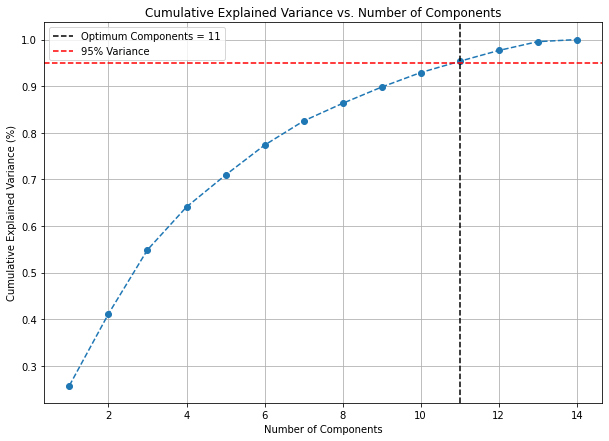

In [15]:
# calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# plotting the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance vs. Number of Components')

# drawing the vertical and horizontal dashed lines for 95% variance
optimum_components = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=optimum_components, color='black', linestyle='--', label=f'Optimum Components = {optimum_components}')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')

plt.legend()
plt.grid(True)
plt.show()

## 5. Normality Test

### K-S Normality Test

In [16]:
# perform K-S test for normality on bedrooms
ks_statistic_bedrooms, ks_pvalue_bedrooms = st.kstest(final_df['bedrooms'], 'norm', args=(final_df['bedrooms'].mean(), final_df['bedrooms'].std()))

# perform K-S test for normality on bathrooms
ks_statistic_bathrooms, ks_pvalue_bathrooms = st.kstest(final_df['bathrooms'], 'norm', args=(final_df['bathrooms'].mean(), final_df['bathrooms'].std()))

print(f"K-S test: statistics={ks_statistic_bedrooms:.2f} p-value={ks_pvalue_bedrooms:.2f}")
print(f"K-S test: Number of bedrooms looks {'normal' if ks_pvalue_bedrooms > 0.01 else 'not normal'} with 99% accuracy")
print(f"K-S test: statistics={ks_statistic_bathrooms:.2f} p-value={ks_pvalue_bathrooms:.2f}")
print(f"K-S test: Number of bathrooms looks {'normal' if ks_pvalue_bathrooms > 0.01 else 'not normal'} with 99% accuracy")

K-S test: statistics=0.20 p-value=0.00
K-S test: Number of bedrooms looks not normal with 99% accuracy
K-S test: statistics=0.48 p-value=0.00
K-S test: Number of bathrooms looks not normal with 99% accuracy


The K-S test results indicate that both features does not follow the Gaussian distribution as the statistics are 0.2 and 0.48 respectively with p-values are 0, which is less than the expected 0.05 found in Gaussian-distributed dataset.

### Shapiro-Wilk Normality Test

In [17]:
# perform Shapiro-Wilk test for normality on bedrooms
shapiro_statistic_bedrooms, shapiro_pvalue_bedrooms = st.shapiro(final_df['bedrooms'])

# perform Shapiro-Wilk test for normality on bathrooms
shapiro_statistic_bathrooms, shapiro_pvalue_bathrooms = st.shapiro(final_df['bathrooms'])

print(f"Shapiro-Wilk test: statistics={shapiro_statistic_bedrooms:.2f} p-value={shapiro_pvalue_bedrooms:.2f}")
print(f"Shapiro-Wilk test: Number of bedrooms looks {'normal' if shapiro_pvalue_bedrooms > 0.01 else 'not normal'} with 99% accuracy")
print(f"Shapiro-Wilk test: statistics={shapiro_statistic_bathrooms:.2f} p-value={shapiro_pvalue_bathrooms:.2f}")
print(f"Shapiro-Wilk test: Number of bathrooms looks {'normal' if shapiro_pvalue_bathrooms > 0.01 else 'not normal'} with 99% accuracy")

Shapiro-Wilk test: statistics=0.90 p-value=0.00
Shapiro-Wilk test: Number of bedrooms looks not normal with 99% accuracy
Shapiro-Wilk test: statistics=0.52 p-value=0.00
Shapiro-Wilk test: Number of bathrooms looks not normal with 99% accuracy


The Shapiro-Wilk test results indicate that both features does not follow the Gaussian distribution as the statistics are 0.9 and 0.52 respectively with p-values are 0, which is less than the expected 0.05 found in Gaussian-distributed dataset.

### D'Agostino's 𝐾^2 Normality Test

In [18]:
# perform DA test for normality on bedrooms
da_statistic_bedrooms, da_pvalue_bedrooms = st.normaltest(final_df['bedrooms'])

# perform DA test for normality on bathrooms
da_statistic_bathrooms, da_pvalue_bathrooms = st.normaltest(final_df['bathrooms'])

print(f"D'Agostino's K^2 test: statistics={da_statistic_bedrooms:.2f} p-value={da_pvalue_bedrooms:.2f}")
print(f"D'Agostino's K^2 test: Number of bedrooms looks {'normal' if da_pvalue_bedrooms > 0.01 else 'not normal'} with 99% accuracy")
print(f"D'Agostino's K^2 test: statistics={da_statistic_bathrooms:.2f} p-value={da_pvalue_bathrooms:.2f}")
print(f"D'Agostino's K^2 test: Number of bathrooms looks {'normal' if da_pvalue_bathrooms > 0.01 else 'not normal'} with 99% accuracy")

D'Agostino's K^2 test: statistics=1497.85 p-value=0.00
D'Agostino's K^2 test: Number of bedrooms looks not normal with 99% accuracy
D'Agostino's K^2 test: statistics=23495.67 p-value=0.00
D'Agostino's K^2 test: Number of bathrooms looks not normal with 99% accuracy


The D'Agostino's K^2 test results indicate that both features does not follow the Gaussian distribution as the statistics are 1497.5 and 23495.67 respectively with p-values are 0, which is less than the expected 0.05 found in Gaussian-distributed dataset.